In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
netcdf_frequency_hours = 6

start_forecast_hours = 0
end_forecast_hours = start_forecast_hours + 23

erode_land = 1 #Er vel såpass langt fra land at dette ikke har noe å si foreløpig

out_folder = os.path.abspath('deterministic_forecast_test')

os.makedirs(out_folder, exist_ok=True)
print("Output will be placed in '" + out_folder + "'")

Output will be placed in '/home/johanna/gpu-ocean/gpu_ocean/demos/Opendrift_Parcels/deterministic_forecast_test'


In [5]:
url_list = ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
            '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
            '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']

In [6]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
}
data_args = NetCDFInitialization.getInitialConditions(url_list, 376, 432, 487,543 , 
                     timestep_indices = None, erode_land = erode_land, download_data = False)

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

forecast_netcdf = os.path.join(out_folder,"_deterministic_forecast.nc")



This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [7]:
observation_args = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }

trajectory_forecast = Observation.Observation(**observation_args)

trajectory_forecast_filename = 'trajectory_forecast_'+str(start_forecast_hours)+'_to_'+str(end_forecast_hours)+'.pickle'
trajectory_forecast_path = os.path.join(out_folder, trajectory_forecast_filename)

In [8]:
trajectory_forecast_path

'/home/johanna/gpu-ocean/gpu_ocean/demos/Opendrift_Parcels/deterministic_forecast_test/trajectory_forecast_0_to_69.pickle'

In [9]:
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, 1,
                                                     boundaryConditions = sim.boundary_conditions,
                                                     domain_size_x = trajectory_forecast.domain_size_x,
                                                     domain_size_y = trajectory_forecast.domain_size_y,
                                                     gpu_stream = sim.gpu_stream)

In [10]:
try:
    num_total_hours = end_forecast_hours
    
    five_mins_in_an_hour = 12
    sub_dt = 5*60 # five minutes
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)

    netcdf_counter = 0
    for hour in range(num_total_hours):
        
        if hour == start_forecast_hours:
            # Attach drifters
            drifter_positions = np.array([[400.5
                                           *800-302400,513.57*800-391200]])
            drifters.setDrifterPositions(drifter_positions)
            sim.attachDrifters(drifters)
            trajectory_forecast.add_observation_from_sim(sim)
        
        for mins in range(five_mins_in_an_hour):
            t = sim.step(sub_dt)
            if hour >= start_forecast_hours:
                trajectory_forecast.add_observation_from_sim(sim)
        
        pp.update(progress.getPrintString(hour/(end_forecast_hours-1)))

except Exception as e:
    print("Something went wrong:" + str(e))
    raise e
    
trajectory_forecast.to_pickle(trajectory_forecast_path)

'0% [##############################] 100%. Total: 3m 0s, elapsed: 3m 0s, remaining: 0s'

In [11]:
def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:black', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.3)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.7)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)
        
def createForecastCanvas(observation):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/1000
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax


def plotAllDrifters(obs_file, drifter_ids=None, ax = None):
    
    if drifter_ids is None:
        drifter_ids = np.arange(obs_file.get_num_drifters(ignoreBuoys=True))
    
    num_drifters = len(drifter_ids)
    
    drifter_paths = [None]*num_drifters

    forecast_start_t = start_forecast_hours*3600
    forecast_end_t = end_forecast_hours*3600


    for i in range(num_drifters):
        drifter_paths[i] = obs_file.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t)

    if ax is None:
        ax = createForecastCanvas(trajectory_forecast)
    for drifter_path in drifter_paths:
        forecastPlot(ax, drifter_path, [], truth_point_size=1)


In [12]:
drifter_path = trajectory_forecast.get_drifter_path(0,start_forecast_hours*3600, end_forecast_hours*3600)
print(drifter_path)

[array([[18.00091992, 19.65795312],
       [18.00117188, 19.66052734],
       [18.00140039, 19.66220313],
       ...,
       [18.39405273, 19.33316602],
       [18.39621875, 19.33251562],
       [18.39838477, 19.33186523]])]


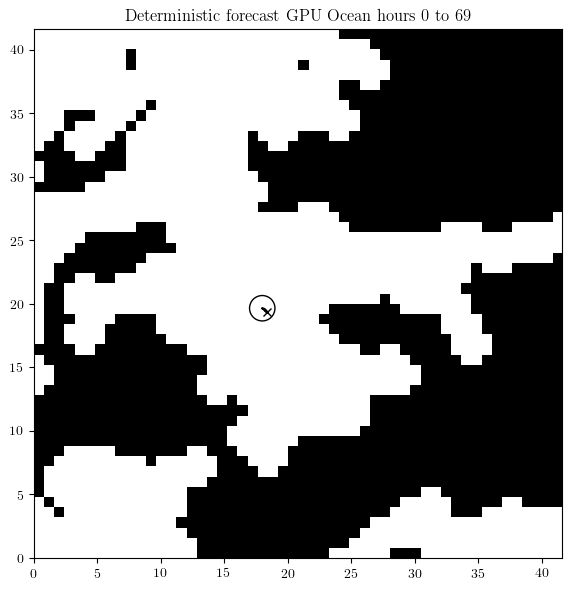

In [13]:
dt_string = 'hours ' + str(start_forecast_hours) + ' to ' + str(end_forecast_hours)

plotAllDrifters(trajectory_forecast)
plt.title('Deterministic forecast GPU Ocean ' + dt_string)
plt.savefig(os.path.join(out_folder, 'gpuocean_forecasts.pdf'))

In [16]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.oceandrift import OceanDrift
from netCDF4 import Dataset
from datetime import timedelta

In [27]:
def opendriftObj2gpuoceanObs(o, x0, x1,y0,y1, norkyst_X, norkyst_Y, land_mask = None):
    t = o.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    x = x - norkyst_X[x0 + 2]
    y = y- norkyst_Y[y0 + 2]

    nx = (x1-x0-4)
    ny = (y1-y0-4)
    
    obs = Observation.Observation(domain_size_x = nx*800,
                                    domain_size_y = ny*800,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)
    
    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean
    
    return obs

def xyopendrift2gpuocean(o,lon,lat,x0,x1, norkyst_X, norkyst_Y):
    x,y = o.lonlat2xy(lon,lat)
    
    x = x - norkyst_X[x0 + 2]
    y = y- norkyst_Y[y0 + 2]
    
    return x,y

In [20]:
def simulate_opendrift(source_url, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
    o = OceanDrift(loglevel=20)
    
    if velocity_average:
        reader_norkyst.variable_mapping['x_sea_water_velocity'] = 'ubar'
        reader_norkyst.variable_mapping['y_sea_water_velocity'] = 'vbar'
    
    o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
    
    o.seed_elements(lon= lon, lat=lat, radius=1, number=1, time=reader_norkyst.start_time, wind_drift_factor = wind_drift_percentage)
    
    o.set_config('drift:scheme', 'runge-kutta4')
    
    o.run(duration = timedelta(hours=hours), time_step = 300, time_step_output = 900)
    
    return o

In [21]:
ncfile = Dataset(url_list[0])
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

In [24]:
o = simulate_opendrift(url_list[0], 60.12,5.55, 0.0, True,12) #no wind, average velocity

13:23:09 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
13:23:09 INFO: Opening file with Dataset
13:23:09 INFO: OpenDriftSimulation initialised (version 1.2.3)
13:23:09 INFO: Config validation OK
13:23:09 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
13:23:12 INFO: Using existing reader for land_binary_mask
13:23:12 INFO: All points are in ocean
13:23:12 INFO: 2019-07-16 00:00:00 - step 1 of 144 - 1 active elements (0 deactivated)
  condition = (xf < v1) | (xf > v2)

  condition = (xf < v1) | (xf > v2)

13:23:12 INFO: 2019-07-16 00:05:00 - step 2 of 144 - 1 active elements (0 deactivated)
13:23:12 INFO: 2019-07-16 00:10:00 - step 3 of 144 - 1 active elements (0 deactivated)
13:23:12 INFO: 2019-07-16 00:15:00 - step 4 of 144 - 1 active elements (0 deactivated)
13:23:12 INFO: 2019-07-16 00:20:00 - step 5 of 144 - 1 ac

13:23:13 INFO: 2019-07-16 06:55:00 - step 84 of 144 - 1 active elements (0 deactivated)
13:23:13 INFO: 2019-07-16 07:00:00 - step 85 of 144 - 1 active elements (0 deactivated)
13:23:13 INFO: 2019-07-16 07:05:00 - step 86 of 144 - 1 active elements (0 deactivated)
13:23:13 INFO: 2019-07-16 07:10:00 - step 87 of 144 - 1 active elements (0 deactivated)
13:23:13 INFO: 2019-07-16 07:15:00 - step 88 of 144 - 1 active elements (0 deactivated)
13:23:13 INFO: 2019-07-16 07:20:00 - step 89 of 144 - 1 active elements (0 deactivated)
13:23:13 INFO: 2019-07-16 07:25:00 - step 90 of 144 - 1 active elements (0 deactivated)
13:23:14 INFO: 2019-07-16 07:30:00 - step 91 of 144 - 1 active elements (0 deactivated)
13:23:14 INFO: 2019-07-16 07:35:00 - step 92 of 144 - 1 active elements (0 deactivated)
13:23:14 INFO: 2019-07-16 07:40:00 - step 93 of 144 - 1 active elements (0 deactivated)
13:23:14 INFO: 2019-07-16 07:45:00 - step 94 of 144 - 1 active elements (0 deactivated)
13:23:14 INFO: 2019-07-16 07:50:

In [25]:
obs = opendriftObj2gpuoceanObs(o,376, 432, 487,543 ,X, Y )

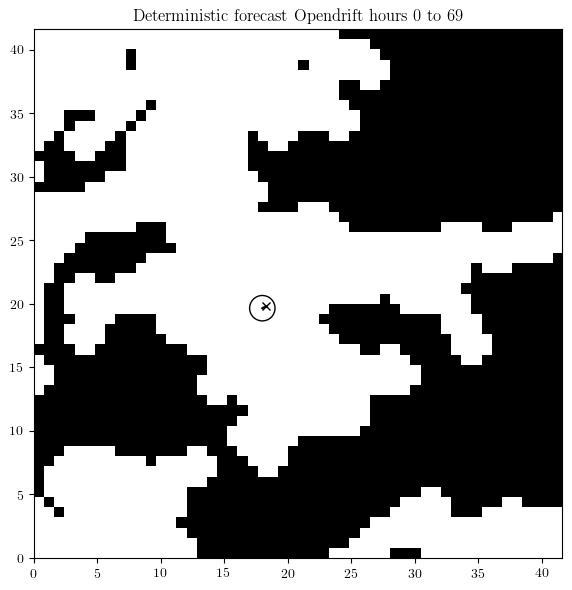

In [26]:
dt_string = 'hours ' + str(start_forecast_hours) + ' to ' + str(end_forecast_hours)

plotAllDrifters(obs)
plt.title('Deterministic forecast Opendrift ' + dt_string)
plt.savefig(os.path.join(out_folder, 'gpuocean_forecasts.pdf'))